# Source code of the Paper *Solar Irradiance Forecasting to Short-Term PV Power: Accuracy Comparison of ANN and LSTM Models*

This repository contains the source code for the full paper PDF available at [[Wentz et al. 2022]](https://doi.org/10.3390/en15072457).

**We encourage the spirit of researchers to contribute to more reliable and reproducible studies.**

Please, if you use this source code or part of it, cite:
*   Wentz, V.H.; Maciel, J.N.; Gimenez Ledesma, J.J.; Ando Junior, O.H. Solar Irradiance Forecasting to Short-Term PV Power: Accuracy Comparison of ANN and LSTM Models. Energies 2022, 15, 2457.

## Gattering data from online dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from train_utils import *
from utils import *

In [ ]:
data_irradiance = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_irradiance.csv?download=1",
                              index_col = 'timeStamp', parse_dates=True)

data_weather = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_weather.csv?download=1",
                           index_col = 'timeStamp', parse_dates=True)

data_weather["month"] = data_weather.index.month
data_weather["day"] = data_weather.index.day
data_weather["hour"] = data_weather.index.hour
data_weather["minute"] = data_weather.index.minute





In [ ]:
data = pd.concat([data_weather, data_irradiance['ghi']], axis = 1)

In [ ]:
data.dropna(inplace=True)
data_clean = data[['air_temp', 'windsp', 'winddir', 'month', 'day', 'hour', 'minute','ghi']].copy()

## Dataset features initial analysis

**Variables dictionary**

`timeStamp`: Date and time (in UTC format). \\
`air_temp`: Air temperature. \\
`relhum`: Relative humidity of the air. \\
`press`: Pressure at sea level. \\
`windsp`: Wind speed.
`winddir`: Wind direction.
`max_windsp`: Maximum wind speed.
`precipitation`: Precipitation.
`ghi`: Global Horizontal Irradiance.
All variables are in the International System (IS).



#### Show first five lines of dataset

In [ ]:
data.head()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,ghi
timeStamp,,,,,,,,
2014-01-02 08:00:00,7.32,56.56,1010.0,1.80,43.61,3.7,0.0,0.0
2014-01-02 08:01:00,7.26,56.82,1010.0,2.00,48.40,3.1,0.0,0.0
2014-01-02 08:02:00,7.20,56.96,1010.0,1.90,31.80,3.7,0.0,0.0
2014-01-02 08:03:00,7.14,57.12,1010.0,1.44,38.98,2.5,0.0,0.0
2014-01-02 08:04:00,7.08,57.36,1010.0,1.84,34.21,2.8,0.0,0.0


#### Variable types information.
All variables are numeric.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1552320 entries, 2014-01-02 08:00:00 to 2016-12-31 07:59:00
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   air_temp       1551702 non-null  float64
 1   relhum         1551702 non-null  float64
 2   press          1551702 non-null  float64
 3   windsp         1551702 non-null  float64
 4   winddir        1551702 non-null  float64
 5   max_windsp     1551702 non-null  float64
 6   precipitation  1551702 non-null  float64
 7   ghi            1552320 non-null  float64
dtypes: float64(8)
memory usage: 106.6 MB


#### Missind data treatment (27%)

In [ ]:
print(f'{(data.isna().sum().sort_values().sum() / data.shape[0]) * 100} % ')
data.isna().sum().sort_values()

0.2786796536796537 % 


ghi                0
air_temp         618
relhum           618
press            618
windsp           618
winddir          618
max_windsp       618
precipitation    618
dtype: int64

In [ ]:
is_Null = data.isnull()
mask_nan = is_Null.any(axis = 1)
row_with_nan = data[mask_nan]
print(row_with_nan)

                     air_temp  relhum  press  ...  max_windsp  precipitation     ghi
timeStamp                                     ...                                   
2014-01-16 03:18:00       NaN     NaN    NaN  ...         NaN            NaN    0.00
2014-01-16 03:19:00       NaN     NaN    NaN  ...         NaN            NaN    0.00
2014-01-16 03:20:00       NaN     NaN    NaN  ...         NaN            NaN    0.00
2014-01-16 03:21:00       NaN     NaN    NaN  ...         NaN            NaN    0.00
2014-01-16 03:22:00       NaN     NaN    NaN  ...         NaN            NaN    0.00
...                       ...     ...    ...  ...         ...            ...     ...
2014-07-23 21:31:00       NaN     NaN    NaN  ...         NaN            NaN  897.43
2014-07-23 21:32:00       NaN     NaN    NaN  ...         NaN            NaN  896.29
2014-07-24 18:08:00       NaN     NaN    NaN  ...         NaN            NaN  830.80
2014-07-24 18:09:00       NaN     NaN    NaN  ...         NaN    

In [ ]:
data_clean = data.dropna().copy()

#### Descriptive statistics

In [ ]:
data_clean.describe()

,air_temp,relhum,press,windsp,winddir,max_windsp,precipitation,ghi
count,1.551702e+06,1.551702e+06,1.551702e+06,1.551702e+06,1.551702e+06,1.551702e+06,1.551702e+06,1.551702e+06
mean,1.747452e+01,5.457541e+01,1.003680e+03,1.335163e+00,1.820725e+02,2.141872e+00,2.721347e-03,2.086203e+02
std,8.237586e+00,2.240947e+01,5.038982e+00,8.299051e-01,8.314905e+01,1.251351e+00,3.681996e-02,2.953537e+02
min,-3.300000e+00,4.860000e+00,9.830000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.140000e+01,3.566000e+01,1.000000e+03,7.400000e-01,1.214000e+02,1.200000e+00,0.000000e+00,0.000000e+00
50%,1.612000e+01,5.506000e+01,1.003000e+03,1.180000e+00,1.662000e+02,1.900000e+00,0.000000e+00,3.290000e+00
75%,2.270000e+01,7.436000e+01,1.007000e+03,1.720000e+00,2.599000e+02,2.700000e+00,0.000000e+00,3.871000e+02
max,4.278000e+01,9.400000e+01,1.021000e+03,9.300000e+00,3.600000e+02,1.680000e+01,5.040000e+00,1.466000e+03


#### Visualization

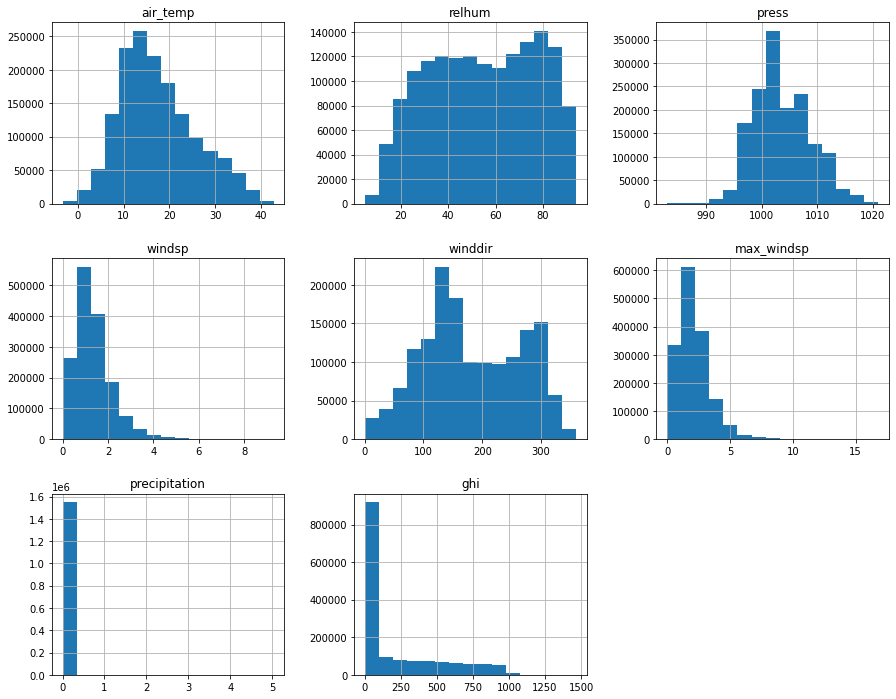

In [ ]:
data_clean.hist(bins = 15, figsize=(15,12));

### Treatment of data for training

What do we have to do?
- Normalization
- Separation of the folds (3 folds)
   - 2014 and 2015 as training, December as validation; (2016 test)
   - 2015 and 2016 as training, December as validation; (2014 test)
   - 2016 and 2014 as training, December as validation; (2015 test)
  
1 month to minute = 43800

In [ ]:
def data_train_test(data, year, ghi):

    train = data[data.index.year != year]
    
    test = data[data.index.year == year]

    trainNorm = 0.1 + 0.8 * ((train - train.min()) /
                             (train.max() - train.min()))
    
    testNorm = 0.1 + 0.8 * ((test - test.min()) / (test.max() - test.min()))

    TrainDataset = np.hstack([trainNorm[i].values.reshape(
        (len(trainNorm[i]), 1)) for i in trainNorm.columns])
    TestDataset = np.hstack([testNorm[i].values.reshape(
        (len(testNorm[i]), 1)) for i in testNorm.columns])

    if ghi:
        # Train
        X_train, y_train = split_sequences_ghi(TrainDataset[:1028982-43680], 1)

        # Validation
        X_val, y_val = split_sequences_ghi(
            TrainDataset[1028982-43680:], 1)

        # test
        X_test, y_test = split_sequences_ghi(TestDataset, 1)

    else:
        # Train
        X_train, y_train = split_sequences_ghi(TrainDataset[:1028982-43680], 1)

        # Validation
        X_val, y_val = split_sequences_ghi(TrainDataset[1028982-43680:], 1)

        # test
        X_test, y_test = split_sequences_ghi(TestDataset, 1)

    n_in = X_train.shape[1] * X_train.shape[2]

    X_train = X_train.reshape((X_train.shape[0], n_in))

    X_val = X_val.reshape((X_val.shape[0], n_in))

    X_test = X_test.reshape((X_test.shape[0], n_in))

    return n_in, X_train, y_train, X_val, y_val, X_test, y_test

### Machine Learning imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import os
import time

## Training Models

### ANN

#### Create ANN model

In [ ]:
def get_model(n_in: int,
              n_out: int,
              nLayers: list,
              dropout: float = 0.15,
              batchNorm: bool = False,
              activ: str = "relu"
              ) -> tf.keras.models.Sequential:
    """[summary]
    Args:
        n_in (int): [description]
        n_out (int): [description]
        nLayers (list): [description]
        dropout (float, optional): [description]. Defaults to 0.15.
        batchNorm (bool, optional): [description]. Defaults to False.
        activ (str, optional): [description]. Defaults to "relu".
    Returns:
        tf.keras.models.Sequential: [description]
    """
    model = Sequential()

    seed = 2459

    if batchNorm:


        for layer in nLayers:
            model.add(Dense(layer,
                            activation=activ,
                            kernel_initializer=GlorotNormal(seed=seed),
                            input_shape=(n_in,)))
            model.add(BatchNormalization())
            model.add(Dropout(dropout))
            n_in = layer

        model.add(Dense(n_out, input_shape=(n_in,)))

        return model

    elif not batchNorm:
        for layer in nLayers:
            model.add(Dense(layer,
                            activation=activ,
                            kernel_initializer=GlorotNormal(seed=seed),
                            input_shape=(n_in,)))
            model.add(Dropout(dropout))
            n_in = layer

        model.add(Dense(n_out, input_shape=(n_in,)))

        return model

### ANN Training

#### Complete Variables

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr # 0.01
  else:
    return lr * tf.math.exp(-0.1) # 0.0001 -> 0000....1111

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LearningRateScheduler

save_model = "/content/Modelos/ANN/teste_teste.h5"

early = EarlyStopping(monitor="val_loss", patience=10)

save = ModelCheckpoint(filepath=save_model,
                         monitor = "val_loss",
                         save_best_only=True)
 
learningRateScheduler = LearningRateScheduler(scheduler)

model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
                )


with tf.device('/device:GPU:0'):

  model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=32,
                    verbose=0,
                    callbacks=[early, save, learningRateScheduler])

In [ ]:
for year in [2016, 2014, 2015]:
  # Pegar os dados:
  n_in, X_train, y_train, X_val, y_val, X_test, y_test = data_train_test(data_clean, year, ghi=False)

  # Pegar modelo:
  model = get_model(n_in, 1, nLayers = [30,30])

  save_model = "/content/Modelos/ANN/teste_"+str(year)+".h5"

  early = EarlyStopping(monitor="val_loss", patience=10)

  save = ModelCheckpoint(filepath=save_model,
                         monitor = "val_loss",
                         save_best_only=True)
  
  learningRateScheduler = LearningRateScheduler(scheduler)
  
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  rmse = tf.keras.metrics.RootMeanSquaredError()

  clear_session()

  

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[rmse, mape])

  print(f"[INFO] Train model. {year}")
  start = time.time()
  with tf.device('/device:GPU:0'):
    model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=32,
                    verbose=0,
                    callbacks=[early, save, learningRateScheduler])
  end = time.time()
  


[INFO] Train model. 2016
[INFO] Train model. 2014
[INFO] Train model. 2015


In [ ]:
!zip -r "/content/ANN2.zip" "/content/Modelos/ANN"

updating: content/Modelos/ANN/ (stored 0%)
  adding: content/Modelos/ANN/teste_2015.h5 (deflated 69%)
  adding: content/Modelos/ANN/teste_2016.h5 (deflated 70%)
  adding: content/Modelos/ANN/teste_2014.h5 (deflated 74%)


#### Reduced Variables

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
for year in [2016, 2014, 2015]:
  # Pegar os dados:
  n_in, X_train, y_train, X_val, y_val, X_test, y_test = data_train_test(data_clean, year, ghi=False)

  # Pegar modelo:
  model = get_model(n_in, 1, nLayers = [30,30])

  save_model = "/content/Modelos/ANN/teste_red_"+str(year)+".h5"

  early = EarlyStopping(monitor="val_loss", patience=10)

  save = ModelCheckpoint(filepath=save_model,
                         monitor = "val_loss",
                         save_best_only=True)
  
  learningRateScheduler = LearningRateScheduler(scheduler)
  
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  rmse = tf.keras.metrics.RootMeanSquaredError()

  clear_session()

  

  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[rmse, mape])

  print(f"[INFO] Train model. {year}")
  start = time.time()
  with tf.device('/device:GPU:0'):
    model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=32,
                    verbose=0,
                    callbacks=[early, save, learningRateScheduler])
  end = time.time()

[INFO] Train model. 2016
[INFO] Train model. 2014
[INFO] Train model. 2015


In [ ]:
!zip -r "/content/ANN_REDUZIDO.zip" "/content/Modelos/ANN"

  adding: content/Modelos/ANN/ (stored 0%)
  adding: content/Modelos/ANN/teste_red_2016.h5 (deflated 70%)
  adding: content/Modelos/ANN/teste_red_2014.h5 (deflated 75%)
  adding: content/Modelos/ANN/teste_red_2015.h5 (deflated 73%)


### LSTM Training

#### Complete variables

In [ ]:
X_train.shape

(985301, 12)

In [ ]:
for year in [2016, 2014, 2015]:

  n_steps = 1
  #n_in, X_train, y_train, X_val, y_val, X_test, y_test = data_train_test(data_clean, year , False)
  #n_features = X_train.shape[1]

  #X_train = X_train.reshape(-1, 1, 12)
  #X_val = X_val.reshape(-1, 1, 12)
  #X_test = X_test.reshape(-1, 1, 12)

  

  model = Sequential([
                    LSTM(30, activation="tanh", return_sequences=True ,input_shape=(n_steps,n_features)),
                    Dropout(0.15),
                    LSTM(30, activation='tanh'),
                    Dense(1)
  ])
  

  


 # save_model = "/content/Modelos/LSTM/teste_LSTM_"+str(year)+".h5"

 # early = EarlyStopping(monitor="val_loss", patience=10)

 # save = ModelCheckpoint(filepath=save_model,
 #                        monitor = "val_loss",
 #                        save_best_only=True)
  
 # learningRateScheduler = LearningRateScheduler(scheduler)
  
 # mape = tf.keras.metrics.MeanAbsolutePercentageError()
 # rmse = tf.keras.metrics.RootMeanSquaredError()

 # clear_session()


 # model.compile(loss="mse",
 #               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
 #               metrics=[rmse, mape])
  
 # clear_session()
 # print(f"[INFO] Train model. {year}")
 # start = time.time()
 # with tf.device('/device:GPU:0'):
 #   model.fit(X_train, y_train,
 #                   validation_data=(X_val, y_val),
 #                   epochs=1000,
 #                   batch_size=32,
 #                   verbose=0,
 #                   callbacks=[early, save, learningRateScheduler])
 # end = time.time()

In [ ]:
!zip -r "/content/LSTM.zip" "/content/Modelos/LSTM"

  adding: content/Modelos/LSTM/ (stored 0%)
  adding: content/Modelos/LSTM/teste_LSTM_2016.h5 (deflated 58%)
  adding: content/Modelos/LSTM/teste_LSTM_2014.h5 (deflated 58%)
  adding: content/Modelos/LSTM/teste_LSTM_2015.h5 (deflated 58%)


#### Reduced variables

In [ ]:
for year in [2016, 2014, 2015]:

  n_steps = 1
  n_in, X_train, y_train, X_val, y_val, X_test, y_test = data_train_test(data_clean, year , False)
  n_features = X_train.shape[1]

  X_train = X_train.reshape(-1, 1, 8)
  X_val = X_val.reshape(-1, 1, 8)
  X_test = X_test.reshape(-1, 1, 8)

  

  model = Sequential([
                    LSTM(30, activation="tanh",return_sequences=True,input_shape=(n_steps,n_features)),
                    Dropout(0.15),
                    LSTM(30, activation='tanh'),
                    Dense(1)
  ])



  save_model = "/content/Modelos/LSTM/teste_LSTM_RED_"+str(year)+".h5"

  early = EarlyStopping(monitor="val_loss", patience=10)

  save = ModelCheckpoint(filepath=save_model,
                         monitor = "val_loss",
                         save_best_only=True)
  
  learningRateScheduler = LearningRateScheduler(scheduler)
  
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  rmse = tf.keras.metrics.RootMeanSquaredError()

  clear_session()


  model.compile(loss="mse",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=[rmse, mape])
  
  clear_session()
  print(f"[INFO] Train model. {year}")
  #start = time.time()
  
  model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    batch_size=32,
                    verbose=0,
                    callbacks=[early, save, learningRateScheduler])
  #end = time.time()

[INFO] Train model. 2016
[INFO] Train model. 2014
[INFO] Train model. 2015


In [ ]:
!zip -r "/content/ANN_REDUZIDO.zip" "/content/Modelos/ANN"

## Testing models

### Automated function to train and test models

In [ ]:
def data_train_test_mod(data, year, ghi):

    train = data[data.index.year != year]
    
    test = data[data.index.year == year]

    twoYear = train.shape[0]
    dec = train[train.index.month == 12].shape[0]

    trainNorm = 0.1 + 0.8 * ((train - train.min()) /
                             (train.max() - train.min()))
    
    testNorm = 0.1 + 0.8 * ((test - test.min()) / (test.max() - test.min()))


    TrainDataset = np.hstack([trainNorm[i].values.reshape(
        (len(trainNorm[i]), 1)) for i in trainNorm.columns])
    TestDataset = np.hstack([testNorm[i].values.reshape(
        (len(testNorm[i]), 1)) for i in testNorm.columns])


    X_train, y_train = split_sequences_ghi(TrainDataset[:twoYear - dec], 1)
    X_train = np.nan_to_num(X_train, nan=0.1)

        
    X_val, y_val = split_sequences_ghi(TrainDataset[twoYear - dec:], 1)
    X_val = np.nan_to_num(X_val, nan=0.1)

        
    X_test, y_test = split_sequences_ghi(TestDataset, 1)
    X_test = np.nan_to_num(X_test, nan=0.1)

    n_in = X_train.shape[1] * X_train.shape[2]

    X_train = X_train.reshape((X_train.shape[0], n_in))

    X_val = X_val.reshape((X_val.shape[0], n_in))

    X_test = X_test.reshape((X_test.shape[0], n_in))

    return n_in, X_train, y_train, X_val, y_val, X_test, y_test

### Test Models with Complete Input Set 

In [ ]:
from glob import glob

In [ ]:
pasta_modelos = sorted(glob("/content/Modelos/Modelos_Completos/*.h5"))

In [ ]:
resultados = {
    "ANN": {
        "RMSE": [],
        "nRMSE": [],
        "MAPE": [],
        "R2": []
    },

    "LSTM": {
        "RMSE": [],
        "nRMSE": [],
        'MAPE': [],
        "R2": []
    }
}

In [ ]:
data_irradiance = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_irradiance.csv?download=1",
                              index_col = 'timeStamp', parse_dates=True)

data_weather = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_weather.csv?download=1",
                           index_col = 'timeStamp', parse_dates=True)

data_weather["month"] = data_weather.index.month
data_weather["day"] = data_weather.index.day
data_weather["hour"] = data_weather.index.hour
data_weather["minute"] = data_weather.index.minute

In [ ]:
#del data
data = pd.concat([data_weather, data_irradiance['ghi']], axis = 1)
data.dropna(inplace=True)
# 15 minutes
#data = data[data.index.minute % 15 == 0]
# 60 minutes
data = data[data.index.minute % 60 == 0]

In [ ]:
results_writer2 = pd.ExcelWriter('valores.xlsx', engine='openpyxl')

In [ ]:
for modelo in pasta_modelos:

  modelo_tipo = modelo.split("/")[-1].split("_")[1]

  year = int(modelo.split("/")[-1].split("_")[-1].split(".")[0])

  model = load_model(modelo)

  if modelo_tipo == "LSTM":
    
    #n_steps = 1

    _, _, _, _, _, X_test, y_test = data_train_test_mod(data, year , False)
    dataFrame_real = pd.DataFrame(y_test)
    dataFrame_real.to_excel(results_writer2, sheet_name=f'valor_real_{year}')

    n_features = X_test.shape[1]

    X_test = X_test.reshape(-1, 1, 12)
    y_test = y_test.reshape(-1,1)

    result = model.predict(X_test)
    dataFrame_predict = pd.DataFrame(result)
    dataFrame_predict.to_excel(results_writer2, sheet_name=f'valor_{modelo_tipo}_predito_{year}')

    #resultados[modelo_tipo]['MAPE'].append(mape2(y_test,result))
    #resultados[modelo_tipo]['RMSE'].append(rmse(y_test,result))
    #resultados[modelo_tipo]['nRMSE'].append(nrmse(y_test,result))
    #resultados[modelo_tipo]['R2'].append(r2_score(y_test,result))


  else:
    _, _, _, _, _, X_test, y_test = data_train_test_mod(data, year , False)

    result = model.predict(X_test)
    
    dataFrame_predict = pd.DataFrame(result)
    dataFrame_predict.to_excel(results_writer2, sheet_name=f'valor_{modelo_tipo}_predito_{year}')

    y_test = y_test.reshape(-1,1)

    #resultados[modelo_tipo]['MAPE'].append(mape2(y_test,result))
    #resultados[modelo_tipo]['RMSE'].append(rmse(y_test,result))
    #resultados[modelo_tipo]['nRMSE'].append(nrmse(y_test,result))
    #resultados[modelo_tipo]['R2'].append(r2_score(y_test,result))



In [ ]:
results_writer2.save()

### Test Models with Reduced Input Set 

In [ ]:
data_irradiance = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_irradiance.csv?download=1",
                              index_col = 'timeStamp', parse_dates=True)

data_weather = pd.read_csv("https://zenodo.org/record/2826939/files/Folsom_weather.csv?download=1",
                           index_col = 'timeStamp', parse_dates=True)

data_weather["month"] = data_weather.index.month
data_weather["day"] = data_weather.index.day
data_weather["hour"] = data_weather.index.hour
data_weather["minute"] = data_weather.index.minute

In [ ]:
del data

data = pd.concat([data_weather, data_irradiance['ghi']], axis = 1)

data.dropna(inplace=True)
data_clean = data[['air_temp', 'windsp', 'winddir', 'month', 'day', 'hour', 'minute','ghi']].copy()

# 15 minutos

#data_clean = data_clean[data_clean.index.minute % 15 == 0]

# 60 minutos
data_clean = data_clean[data_clean.index.minute % 60 == 0]

In [ ]:
from glob import glob
pasta_modelos = sorted(glob("/content/Modelos/Modelos_Reduzidos/*.h5"))

In [ ]:
resultados = {
    "ANN": {
        "RMSE": [],
        "nRMSE": [],
        "MAPE": [],
        "R2": []
    },

    "LSTM": {
        "RMSE": [],
        "nRMSE": [],
        'MAPE': [],
        "R2": []
    }
}

## Saving accuracy results from models predictions

In [ ]:
results_writer = pd.ExcelWriter('valores_red.xlsx', engine='openpyxl')

In [ ]:
for modelo in pasta_modelos:

  modelo_tipo = modelo.split("/")[-1].split("_")[1]

  year = int(modelo.split("/")[-1].split("_")[-1].split(".")[0])

  model = load_model(modelo)

  if modelo_tipo == "LSTM":
    
    #n_steps = 1

    _, _, _, _, _, X_test, y_test = data_train_test_mod(data_clean, year , False)
    dataFrame_real = pd.DataFrame(y_test)
    dataFrame_real.to_excel(results_writer, sheet_name=f'valor_real_{year}')

    n_features = X_test.shape[1]

    X_test = X_test.reshape(-1, 1, 8)
    y_test = y_test.reshape(-1,1)

    result = model.predict(X_test)
    dataFrame_predict = pd.DataFrame(result)
    dataFrame_predict.to_excel(results_writer, sheet_name=f'valor_{modelo_tipo}_RED_predito_{year}')

    resultados[modelo_tipo]['MAPE'].append(mape2(y_test,result))
    resultados[modelo_tipo]['RMSE'].append(rmse(y_test,result))
    resultados[modelo_tipo]['nRMSE'].append(nrmse(y_test,result))
    resultados[modelo_tipo]['R2'].append(r2_score(y_test,result))


  else:
    _, _, _, _, _, X_test, y_test = data_train_test_mod(data_clean, year , False)

    result = model.predict(X_test)
    
    dataFrame_predict = pd.DataFrame(result)
    dataFrame_predict.to_excel(results_writer, sheet_name=f'valor_{modelo_tipo}_RED_predito_{year}')

    y_test = y_test.reshape(-1,1)

    resultados[modelo_tipo]['MAPE'].append(mape2(y_test,result))
    resultados[modelo_tipo]['RMSE'].append(rmse(y_test,result))
    resultados[modelo_tipo]['nRMSE'].append(nrmse(y_test,result))
    resultados[modelo_tipo]['R2'].append(r2_score(y_test,result))

In [ ]:
results_writer.save()

# End.